In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

torch.manual_seed(100)

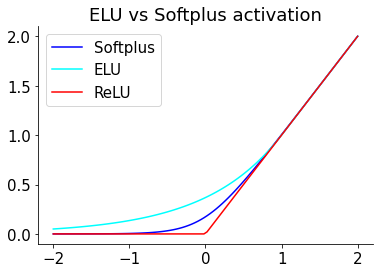

In [2]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
plt.plot(a,F.elu(a-1)+1,color='cyan',label='ELU')
plt.plot(a,F.relu(a),color='red',label='ReLU')

plt.title('ELU vs Softplus activation')
plt.legend()
sns.despine()
plt.show()

In [3]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [4]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, output_size, fbi_size):
        super().__init__()
        self.out_size = output_size
        self.fbi_size = fbi_size
        self.in_size = input_size
        
        self.in2out = nn.Linear(self.in_size, self.out_size, bias=False)
        self.fbi2out = nn.Linear(self.fbi_size, self.out_size, bias=False)
        self.out2fbi = nn.Linear(self.out_size, self.fbi_size, bias=False)
        
        self.in2out.weight.requires_grad = False
        self.fbi2out.weight.requires_grad = False
        self.out2fbi.weight.requires_grad = False
        
        self.in2out.weight.data = n_hot_patterns(n=2,length=7)
        self.out2fbi.weight.data = torch.eye(7).repeat(1,3)
        self.fbi2out.weight.data = torch.eye(7).repeat(1,3).T

        self.in_weight = nn.Parameter(torch.tensor(1.))  
        self.exc_weight = nn.Parameter(torch.tensor(1.))  
        self.inh_weight = nn.Parameter(torch.tensor(-2.))  

            
    def forward(self, input_pattern, out0, fbi0, act_sharpness=4):
        
        out = self.in2out(input_pattern)*self.in_weight + self.fbi2out(fbi0)*self.inh_weight
        out = F.softplus(out, beta=act_sharpness)
#         out = F.relu(out)

        fbi = self.out2fbi(out)*self.exc_weight
        fbi = F.softplus(fbi, beta=act_sharpness)
#         fbi = F.relu(fbi)

        return out, fbi
    
        
    def train(self, num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        output_history = torch.zeros(self.out_size, num_timesteps, num_patterns, num_epochs)
        fbi_history = torch.zeros(self.fbi_size, num_timesteps, num_patterns, num_epochs)
        loss_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.out_size)[pattern_idx]
                
                output = torch.zeros(self.out_size)
                fbi = torch.zeros(self.fbi_size)
                
                loss = 0
                for t in range(num_timesteps): #iterate through all timepoints of the RNN                    
                    if t >= (eval_step - num_BPTT_steps) and t <= eval_step: #truncate BPTT to only evaluate n steps from the end
                        track_grad = True
                    else:
                        track_grad = False
                        
                    with torch.set_grad_enabled(track_grad):
                        output, fbi = self.forward(input_pattern, output, fbi)
                        
                    output_history[:,t,pattern_idx,epoch] = output.detach()
                    fbi_history[:,t,pattern_idx,epoch] = fbi.detach()

                    if t == eval_step:
                        loss += criterion(output, target)
                                                        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_history.append(loss.detach())
  
                self.in_weight.data = self.in_weight.data.clamp(0,100)
                self.inh_weight.data = self.inh_weight.data.clamp(-100,0)
                self.exc_weight.data = self.exc_weight.data.clamp(0,100)
                                        
        return output_history, fbi_history, torch.tensor(loss_history)

In [5]:
# Initialize RNN
input_size = 7
output_size = n_choose_k(7,2)
fbi_size = 7

model = FBI_RNN(input_size, output_size, fbi_size)

100%|██████████| 1000/1000 [00:31<00:00, 32.00it/s]


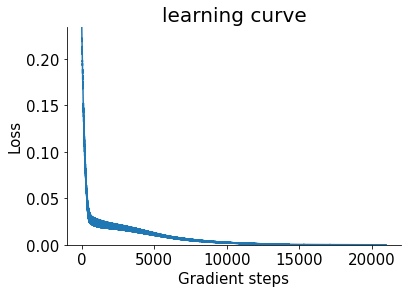

In [6]:
# Train network
num_epochs = 1000
num_timesteps = 15
eval_step = 8
num_BPTT_steps = 5 #how many steps in the past to backpropagate the error
lr = 0.001

all_patterns = n_hot_patterns(n=2,length=input_size)

output_history, fbi_history, loss_history = model.train(num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, lr)

plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)

sns.despine()
plt.show()

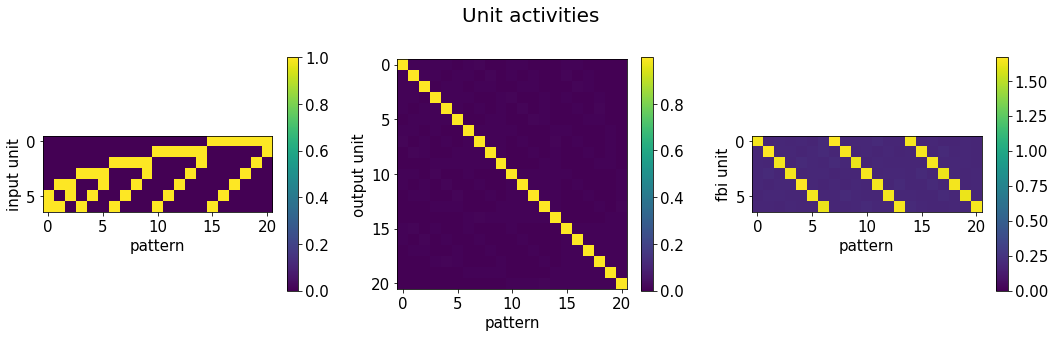

In [7]:
epoch = -1
time = eval_step

fig, ax = plt.subplots(1,3,figsize=(15,4.5))
axis = 0
im = ax[axis].imshow(all_patterns.T,aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('input unit')

axis = 1
im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmin=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('output unit')

axis = 2
im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmin=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('fbi unit')

plt.suptitle("Unit activities",fontsize=20)
plt.tight_layout()
plt.show()

In [8]:
import ipywidgets as widgets

def plot_activity(time):
    epoch = -1

    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity, time=(0,num_timesteps-1,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=7, description='time', max=14), Output()), _dom_classes=('widget-interac…

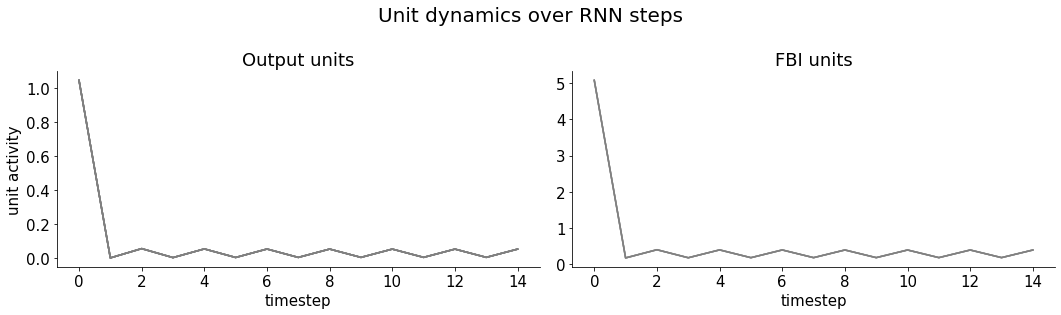

In [9]:
fix, ax = plt.subplots(1,2,figsize=(15,4.5))
for i,_ in enumerate(all_patterns):
    ax[0].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
ax[0].set_xlabel('timestep')
ax[0].set_ylabel('unit activity')
ax[0].set_title('Output units')

for i in range(fbi_size):
    ax[1].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
ax[1].set_xlabel('timestep')
ax[1].set_title('FBI units')  
    
plt.suptitle('Unit dynamics over RNN steps',fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

Weights: 
 in2out = 1.6858667135238647 
 out2fbi = 1.6219350099563599 
 fbi2out = -13.722472190856934


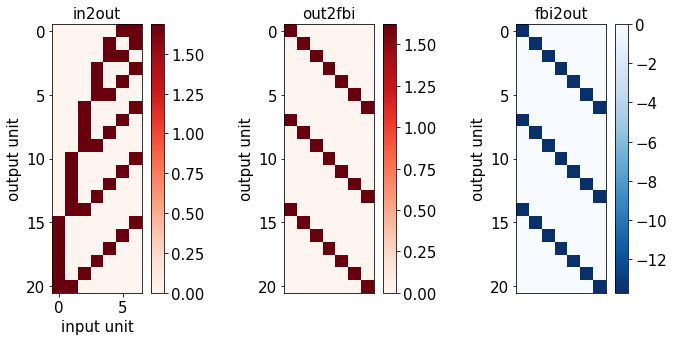

In [10]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

axis = 0
im = ax[axis].imshow(model.in2out.weight.data*model.in_weight.detach(),aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('input unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('in2out',fontsize=15)

axis = 1
im = ax[axis].imshow(model.out2fbi.weight.data.T*model.exc_weight.detach(),aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('output unit')
ax[axis].set_xlabel('fbi unit')
ax[axis].set_title('out2fbi',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

axis = 2
im = ax[axis].imshow(model.fbi2out.weight.data*model.inh_weight.detach(),
                     aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('fbi unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('fbi2out',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

print(f"Weights: \n in2out = {model.in_weight} \n out2fbi = {model.exc_weight} \n fbi2out = {model.inh_weight}")
plt.tight_layout()
plt.show()

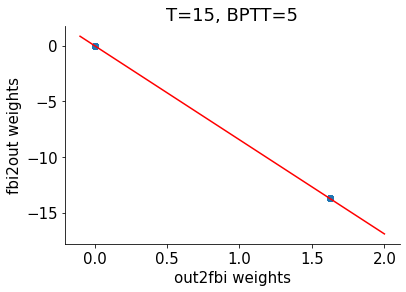

Pearson correlation: r=-0.9999999999999979, r^2=0.9999999999999958, p=0.0


In [11]:
from scipy import stats
x = model.out2fbi.weight.data.T.flatten() * model.exc_weight.detach()
y = model.fbi2out.weight.data.flatten() * model.inh_weight.detach()

plt.scatter(x,y)
plt.xlabel('out2fbi weights')
plt.ylabel('fbi2out weights')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(-0.1,2,2)
y_fit = m*x_fit + b
plt.plot(x_fit, y_fit, c='red')
# print('Linear regression: y = {} x + {}'.format(m,b))

plt.title(f"T={num_timesteps}, BPTT={num_BPTT_steps}")

sns.despine()
plt.show()

r_val, p_val = stats.pearsonr(x, y)
print('Pearson correlation: r={}, r^2={}, p={}'.format(r_val,r_val**2,p_val))